In [53]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import vertica_python

#### Надо проверить некоторых людей действительно ли они похожы на отток и посмотреть паттерны оттока, а также разбить всех пользователей на бины для определения необходимого колличества людей для коммуникации

#### Настроим соединение с вертикой

In [54]:
conn_vert = vertica_python.connect(host = "XXXXX", port=XXXX, user="XXXX", password="XXXXX", database="testdb")
cur_vert = conn_vert.cursor()

#### будем проверять предскаязания по оттоку клиентов

In [ ]:
query = """
select customer_id, date_trunc('week', event_date) as event_date, count(*) from mobile_sessions
where customer_id = 'AMNKIE'
--where customer_id in ('AB9WK2', 'AL7M64', 'ALEWQX', 'ACJFTD', 'AMCEZA', 'H25306', 'AL3OPW', 'E06973', 'AMJXXF', 'ALS3DZ', 'AMROL2', 'AMPN1T', 'AMJ7R8', 'ALCK38', 'AMNXKC', 'AMJFFE', 'ALWCAT', 'AMQL1P', 'AMQYW3', 'AIVFJS')
and event_date > '2016-09-01'
group by customer_id, date_trunc('week', event_date)
order by customer_id, event_date
"""

In [2]:
df = pd.read_csv('/home/alfadata/data/churn/cleaned_df/predictions_all.csv', index_col=0)

In [5]:
df.head()

,client_pin,proba
0,A00327,7.769858e-06
1,A00540,1.328267e-03
2,A03337,1.483949e-02
3,A03339,2.783633e-10
4,A17776,2.120494e-01


In [3]:
df = df.sort_values(by='proba', ascending=False)

In [4]:
df.head()

,client_pin,proba
80564,AB9WK2,0.978379
760525,AL7M64,0.948193
786330,ALEWQX,0.940144
162626,ACJFTD,0.939424
886961,AMCEZA,0.937349


In [13]:
df.tail()

,client_pin,proba
67135,AB1UMH,0.0
841543,ALS94Z,0.0
77339,AB80E4,0.0
615896,AJUT62,0.0
316278,AFDI1D,0.0


In [57]:
df[df.client_pin == 'E06973']

,client_pin,proba
1020249,E06973,0.900236


In [16]:
df[df.proba == 0].sample(5)

,client_pin,proba
836041,ALR7F3,0.0
185451,AD2J3V,0.0
671646,AKG8MJ,0.0
890434,AMD5H1,0.0
145109,AC8YZ0,0.0


In [45]:
df[df.proba > 0.6].sample(5)

,client_pin,proba
771116,ALAM65,0.802348
977538,AMNKIE,0.691465
953803,AMKVT0,0.774446
149679,ACBGTN,0.739745
476352,AHXCHZ,0.767884


In [12]:
print(tuple(df.iloc[:20, 0].tolist()))

('AB9WK2', 'AL7M64', 'ALEWQX', 'ACJFTD', 'AMCEZA', 'H25306', 'AL3OPW', 'E06973', 'AMJXXF', 'ALS3DZ', 'AMROL2', 'AMPN1T', 'AMJ7R8', 'ALCK38', 'AMNXKC', 'AMJFFE', 'ALWCAT', 'AMQL1P', 'AMQYW3', 'AIVFJS')


In [10]:
df.proba.shape

(1070807,)

In [56]:
(df.proba < 0.1).sum()

568666

In [52]:
(df.proba < 0.01).sum()

396995

#### Посмотрим на распределение вероятностей оттока. Все выглядит неплохо потому что у большинства клиентов действительно вероятность оттока маленькая

/opt/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


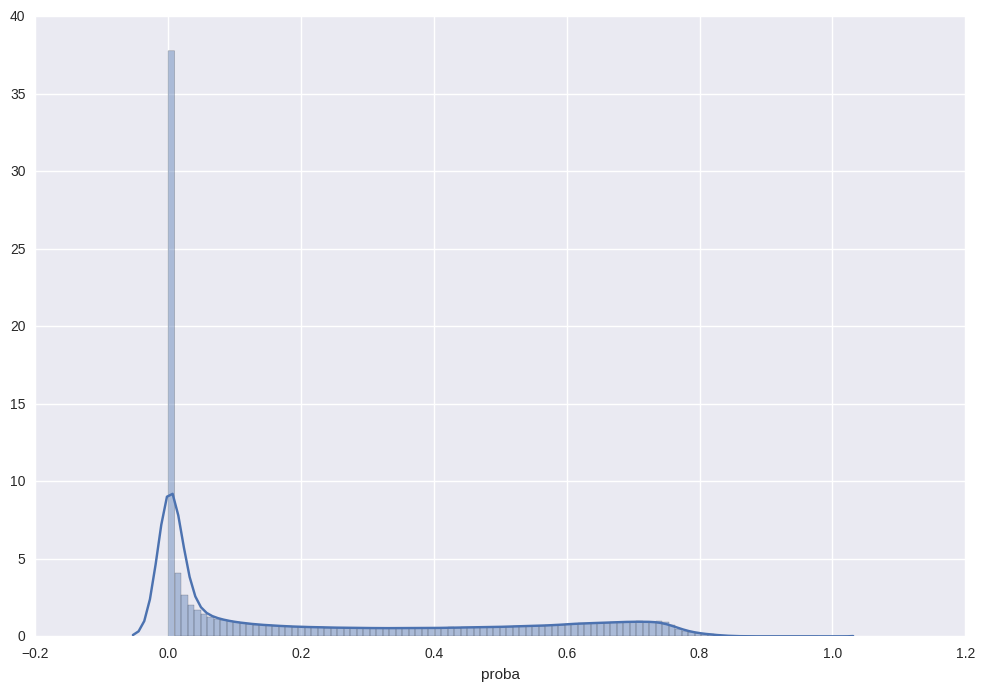

In [6]:
fig, ax = plt.subplots(1, figsize=(12, 8))
sns.distplot(df.proba, ax=ax, bins=100)

In [22]:
np.arange(0, 1.1, 0.1)

array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ])

#### Разобьем всех клиентов на бины по предсказаниям 

In [71]:
bins_range = np.arange(0, 1.001, 0.05)
bins_proba = pd.cut(df.proba, bins=bins_range, right=False).rename('bins_proba')
df_counts = pd.concat([df, bins_proba], axis=1).groupby('bins_proba').size()
df_counts_cumsum = pd.concat([df, bins_proba], axis=1).groupby('bins_proba').size()[::-1].cumsum()[::-1]
pd.concat([df_counts.rename('count_per_prob'), df_counts_cumsum.rename('cumsum')], axis=1)

,count_per_prob,cumsum
bins_proba,,
"[0, 0.05)",506998,1070807
"[0.05, 0.1)",61668,563809
"[0.1, 0.15)",42863,502141
"[0.15, 0.2)",35207,459278
"[0.2, 0.25)",31363,424071
"[0.25, 0.3)",29396,392708
"[0.3, 0.35)",28233,363312
"[0.35, 0.4)",28611,335079
"[0.4, 0.45)",29723,306468


In [66]:
q = pd.concat([df, bins_proba], axis=1).groupby('bins_proba').size()[::-1].cumsum()[::-1]

In [67]:
q

bins_proba
[0, 0.05)      1070807
[0.05, 0.1)     563809
[0.1, 0.15)     502141
[0.15, 0.2)     459278
[0.2, 0.25)     424071
[0.25, 0.3)     392708
[0.3, 0.35)     363312
[0.35, 0.4)     335079
[0.4, 0.45)     306468
[0.45, 0.5)     276745
[0.5, 0.55)     245462
[0.55, 0.6)     210989
[0.6, 0.65)     172851
[0.65, 0.7)     128325
[0.7, 0.75)      79491
[0.75, 0.8)      28375
[0.8, 0.85)       4676
[0.85, 0.9)         60
[0.9, 0.95)          8
[0.95, 1)            1
dtype: int64